# DATA 607 - Machine Learning

## Class 7 Mini-Lecture &mdash; 2025.07.16

### Regularization: LASSO

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedKFold,
)
from sklearn.linear_model import (
    Lasso,
    LogisticRegression,
    Ridge,
)
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

### Model complexity

- The size of the coefficient vector $\beta$ is a reflection of linear model complexity. 

- There are many ways of measuring the size of a vector. For example:

  - square of squares:&nbsp; $\displaystyle\sum_i\beta_i^2$

  - sum of absolute values:&nbsp; $\displaystyle\sum_i|\beta_i|$

### Penalizing model complexity

- Write $\Omega(\beta)$ for any of the above size measures.

- Linear regression fits a model by minimizing the usual loss function given by sum of squared errors:
  $$
  \min_\beta \|y - X\beta\|^2
  $$

- Penalized variants of linear regression minimize penalized loss functions:
  $$
  \|y - X\beta\|^2 + \alpha\,\Omega(\beta)
  $$

  $\alpha$ is a tunable parameter.

### Ridge regression

- Penalized linear regression with $\Omega(\beta) = \text{sum of squared coefficients} = \sum_i\beta_i^2$.

- Use `sklearn.linear_model.Ridge`. Penalty `alpha` has default value `1`.

- Scale your features (e.g., `StandardScaler`) when using ridge regression!

#### Shrinkage

In [3]:
df = pd.read_csv(
    "data/auto_preprocessed.csv",
)
X = df.copy()
y = X.pop("mpg")

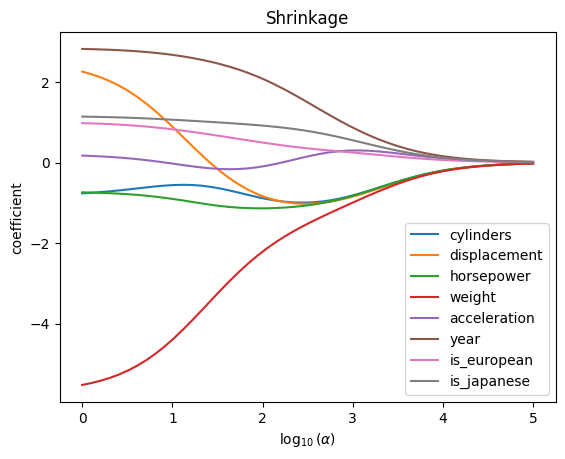

In [4]:
alphas = np.logspace(0, 5, 50)

coefs = np.zeros((50, len(X.columns)))

for i, alpha in enumerate(alphas):
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    model.fit(X, y)
    coefs[i] = model[-1].coef_

coefs = pd.DataFrame({c: np.array(coefs)[:, i] for i, c in enumerate(list(X.columns))})
coefs["logalpha"] = np.log10(alphas)

coefs.plot(x="logalpha")
plt.xlabel("$\\log_{10}(\\alpha)$")
plt.ylabel("coefficient")
plt.title("Shrinkage")
plt.show()

In [ ]:
# Note to self: Long! Do not rerun-live!

param_grid = {
    "polynomialfeatures__degree": [2, 3, 4, 5],
    "ridge__alpha": np.logspace(-2, 1.5, 50),
}

model = make_pipeline(PolynomialFeatures(include_bias=False), StandardScaler(), Ridge())

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=100, random_state=42),
)

search.fit(X, y)

print(f"{search.best_params_=}")
print(f"{-search.best_score_=}")

search.best_params_={'polynomialfeatures__degree': 3, 'ridge__alpha': np.float64(0.08483428982440717)}
-search.best_score_=np.float64(7.5021598350501995)


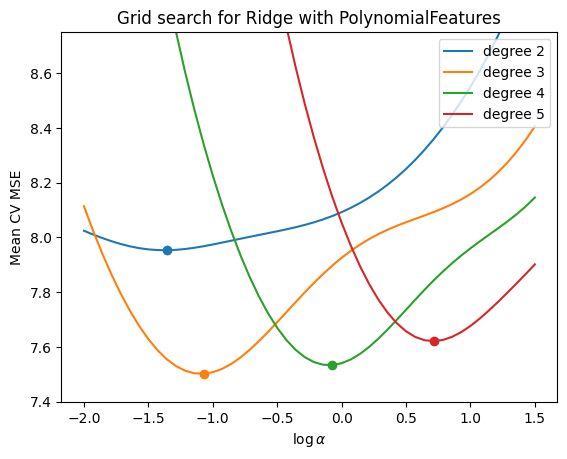

In [6]:
results = pd.DataFrame(search.cv_results_)
for degree, group in results.groupby("param_polynomialfeatures__degree"):
    logalpha = np.log10(group["param_ridge__alpha"].to_numpy())
    meanmse = -group["mean_test_score"].to_numpy()
    j = meanmse.argmin()
    plt.plot(logalpha, meanmse, label=f"degree {degree}")
    plt.plot(logalpha[j], meanmse[j], "o", color=f"C{degree - 2}")

plt.legend(loc="upper right")
plt.ylim(7.4, 8.75)
plt.xlabel("$\\log\\alpha$")
plt.ylabel("Mean CV MSE")
plt.title("Grid search for Ridge with PolynomialFeatures")

plt.show()

### The LASSO

"Least Absolute Selection and Shrinkage Operator"

In [7]:
from sklearn.model_selection import KFold

model = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=2),
    StandardScaler(),
    Lasso(alpha=1e-3, max_iter=1000000),
)

cross_val_score(
    model, X, y, scoring="neg_mean_squared_error", cv=KFold(shuffle=True)
).mean()

np.float64(-8.230824737985907)

In [8]:
# Note to self: Long! Do not rerun-live!

param_grid = {
    "polynomialfeatures__degree": [2],
    "lasso__alpha": np.logspace(-3.5, -2.5, 10),
}

model = make_pipeline(
    PolynomialFeatures(include_bias=False), StandardScaler(), Lasso(max_iter=1000000)
)

search = GridSearchCV(
    model,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=RepeatedKFold(n_repeats=10),
    verbose=True,
)

search.fit(X, y)

print(f"{search.best_params_=}")
print(f"{-search.best_score_=}")

Fitting 50 folds for each of 10 candidates, totalling 500 fits
search.best_params_={'lasso__alpha': np.float64(0.0014677992676220691), 'polynomialfeatures__degree': 2}
-search.best_score_=np.float64(7.786508339273162)


Text(0, 0.5, 'mean test score')

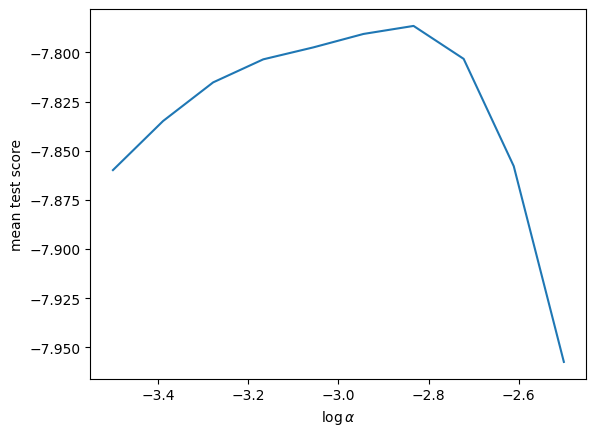

In [9]:
plt.plot(
    np.log10(search.cv_results_["param_lasso__alpha"]),
    search.cv_results_["mean_test_score"],
)
plt.xlabel("$\\log\\alpha$")
plt.ylabel("mean test score")

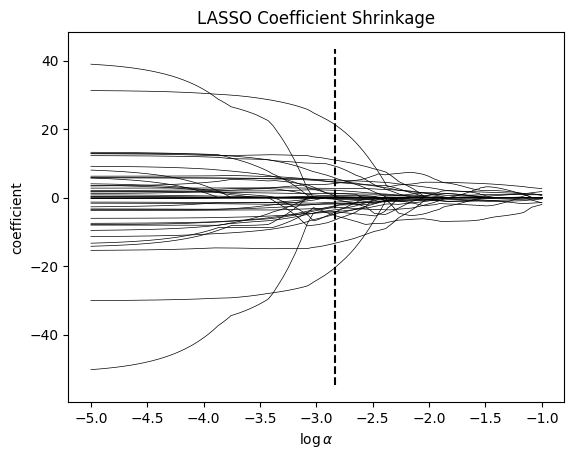

In [10]:
from sklearn.linear_model import lasso_path
from sklearn.pipeline import make_pipeline

preprocessor = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=2), StandardScaler()
)

alphas, coefs, _ = lasso_path(
    preprocessor.fit_transform(X), y, alphas=np.logspace(-5, -1, 1000), max_iter=100000
)

for path in coefs:
    plt.plot(np.log10(alphas), path, "k", lw=0.5)

best_alpha = search.best_params_["lasso__alpha"]
plt.plot([np.log10(best_alpha), np.log10(best_alpha)], plt.ylim(), "k--")

plt.xlabel("$\\log\\alpha$")
plt.ylabel("coefficient")
plt.title("LASSO Coefficient Shrinkage")
plt.show()

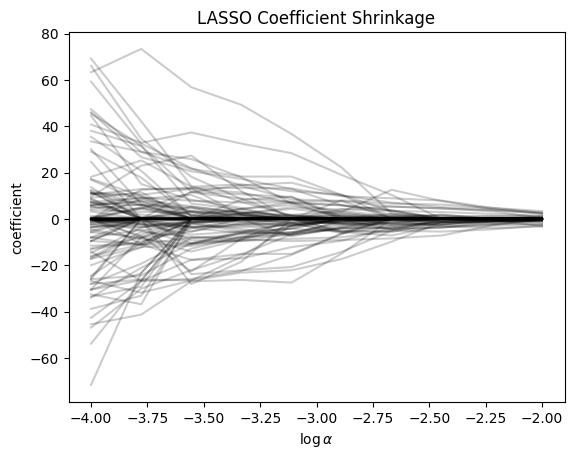

In [11]:
preprocessor = make_pipeline(
    PolynomialFeatures(include_bias=False, degree=3), StandardScaler()
)

alphas, coefs, _ = lasso_path(
    preprocessor.fit_transform(X), y, alphas=np.logspace(-4, -2, 10), max_iter=10000000
)

for path in coefs:
    plt.plot(np.log10(alphas), path, "k", alpha=0.2)


plt.xlabel("$\\log\\alpha$")
plt.ylabel("coefficient")
plt.title("LASSO Coefficient Shrinkage")
plt.show()

##### Back to the ICMR dataset

In [18]:
X = pd.read_csv("~/Downloads/archive-3/data.csv").drop(columns=["Unnamed: 0"])
y = pd.read_csv("~/Downloads/archive-3/labels.csv")["Class"]

cross_val_score(
    LogisticRegression(penalty="l1", solver="liblinear", C=0.01),
    X,
    y,
    scoring="accuracy",
).mean()

/Users/mgreenbe/DATA607S2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/mgreenbe/DATA607S2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/mgreenbe/DATA607S2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be ra

np.float64(1.0)

In [19]:
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X, y)
np.sum(~np.isclose(model.coef_, 0))

/Users/mgreenbe/DATA607S2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


np.int64(212)

In [14]:
set(model.coef_[0].nonzero()[0]).intersection(set(model.coef_[1].nonzero()[0]))

set()

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X_train, y_train)

indices_0 = list(zip(*model.coef_.nonzero()))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model = LogisticRegression(penalty="l1", solver="liblinear", C=0.01)
model.fit(X_train, y_train)

indices_1 = list(zip(*model.coef_.nonzero()))

/Users/mgreenbe/DATA607S2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/Users/mgreenbe/DATA607S2025/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


In [16]:
len(set(indices_0)), len(set(indices_1)), len(
    set(indices_0).intersection(set(indices_1))
)

(165, 155, 102)